The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 多GPU的简洁实现
:label:`sec_multi_gpu_concise`

为每一个新模型从零开始实现并行性并不有趣。此外，优化同步工具以获得高性能也有很大的好处。下面我们将展示如何使用深度学习框架的高级API来实现这一点。数学和算法与 :numref:`sec_multi_gpu` 中的相同。毫不奇怪，你至少需要两个GPU来运行本节的代码。


In [1]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## 简单网络

让我们使用一个比 :numref:`sec_multi_gpu` 的LeNet稍微有意义的网络，它仍然足够容易和快速地训练。我们选择了ResNet-18 :cite:`He.Zhang.Ren.ea.2016`。因为输入的图像很小，所以我们稍微修改一下。与 :numref:`sec_resnet` 的区别在于，我们在开始时使用了更小的卷积核、步长和填充。此外，我们删除了最大池化层。


In [2]:
#@save
def resnet18(num_classes):
    """稍加修改的ResNet-18模型。"""
    def resnet_block(num_channels, num_residuals, first_block=False):
        blk = nn.Sequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.add(
                    d2l.Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(d2l.Residual(num_channels))
        return blk

    net = nn.Sequential()
    # 该模型使用了更小的卷积核、步长和填充，且删除了最大池化层。
    net.add(nn.Conv2D(64, kernel_size=3, strides=1, padding=1),
            nn.BatchNorm(), nn.Activation('relu'))
    net.add(resnet_block(64, 2, first_block=True), resnet_block(128, 2),
            resnet_block(256, 2), resnet_block(512, 2))
    net.add(nn.GlobalAvgPool2D(), nn.Dense(num_classes))
    return net

## 网络初始化


`initialize`函数允许我们在所选设备上初始化参数。有关初始化方法的复习内容，请参阅 :numref:`sec_numerical_stability` 。特别方便的是，它还允许我们同时在多个设备上初始化网络。让我们在实践中尝试一下这是如何运作的。


In [3]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 初始化网络的所有参数
net.initialize(init=init.Normal(sigma=0.01), ctx=devices)

使用 :numref:`sec_multi_gpu` 中引入的 `split_and_load` 函数，我们可以切分一小批数据，并将部分数据复制到`devices`变量提供的设备列表中。网络实例自动使用适当的GPU来计算前向传播的值。在这里，我们生成4个观测值，并通过GPU将它们拆分。


In [4]:
x = np.random.uniform(size=(4, 1, 28, 28))
x_shards = gluon.utils.split_and_load(x, devices)
net(x_shards[0]), net(x_shards[1])

(array([[ 2.2610193e-06,  2.2045974e-06, -5.4046782e-06,  1.2869954e-06,
          5.1373149e-06, -3.8298003e-06,  1.4339014e-07,  5.4683451e-06,
         -2.8279194e-06, -3.9651113e-06],
        [ 2.0698667e-06,  2.0084665e-06, -5.6382501e-06,  1.0498469e-06,
          5.5506416e-06, -4.1065468e-06,  6.0830143e-07,  5.4521765e-06,
         -3.7365030e-06, -4.1891640e-06]], ctx=gpu(0)),
 array([[ 2.4629794e-06,  2.6015521e-06, -5.4362622e-06,  1.2938231e-06,
          5.6387898e-06, -4.1360104e-06,  3.5758922e-07,  5.5125238e-06,
         -3.1957329e-06, -4.2976321e-06],
        [ 1.9431675e-06,  2.2600425e-06, -5.2698206e-06,  1.4807410e-06,
          5.4830930e-06, -3.9678889e-06,  7.5752268e-08,  5.6764361e-06,
         -3.2530238e-06, -4.0943960e-06]], ctx=gpu(1)))

一旦数据通过网络，相应的参数就会在数据通过的设备上初始化。这意味着初始化是在每个设备的基础上进行的。因为我们选择GPU 0和GPU 1进行初始化，所以网络只在那里初始化，而不是在CPU上初始化。事实上，这些参数甚至不存在于CPU上。我们可以通过打印出参数并观察可能出现的任何错误来验证这一点。


In [5]:
weight = net[0].params.get('weight')

try:
    weight.data()
except RuntimeError:
    print('not initialized on cpu')
weight.data(devices[0])[0], weight.data(devices[1])[0]

not initialized on cpu


(array([[[ 0.01382882, -0.01183044,  0.01417866],
         [-0.00319718,  0.00439528,  0.02562625],
         [-0.00835081,  0.01387452, -0.01035946]]], ctx=gpu(0)),
 array([[[ 0.01382882, -0.01183044,  0.01417866],
         [-0.00319718,  0.00439528,  0.02562625],
         [-0.00835081,  0.01387452, -0.01035946]]], ctx=gpu(1)))

接下来，让我们用一个在多个设备上并行工作的代码来替换评估准确性的代码。这是 :numref:`sec_lenet` 的`evaluate_accuracy_gpu`函数的替代。主要区别在于，我们在调用网络之前拆分了一个小批量。其他的基本上都是一样的。


In [6]:
#@save
def evaluate_accuracy_gpus(net, data_iter, split_f=d2l.split_batch):
    """使用多个GPU计算数据集上模型的精度。"""
    # 查询设备列表
    devices = list(net.collect_params().values())[0].list_ctx()
    # 正确预测的数量，预测的总数量
    metric = d2l.Accumulator(2)
    for features, labels in data_iter:
        X_shards, y_shards = split_f(features, labels, devices)
        # 并行运行
        pred_shards = [net(X_shard) for X_shard in X_shards]
        metric.add(
            sum(
                float(d2l.accuracy(pred_shard, y_shard))
                for pred_shard, y_shard in zip(pred_shards, y_shards)),
            labels.size)
    return metric[0] / metric[1]

## 训练

如前所述，训练代码需要执行几个基本功能才能实现高效并行：

* 需要在所有设备上初始化网络参数。
* 在数据集上迭代时，要将小批量划分到所有设备上。
* 我们跨设备并行计算损失及其梯度。
* 聚合梯度，并相应地更新参数。

最后我们计算精度（同样是并行地）来报告网络的最终性能。训练代码与前几章中的实现非常相似，只是我们需要拆分和聚合数据。


In [7]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    ctx = [d2l.try_gpu(i) for i in range(num_gpus)]
    net.initialize(init=init.Normal(sigma=0.01), ctx=ctx, force_reinit=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        timer.start()
        for features, labels in train_iter:
            X_shards, y_shards = d2l.split_batch(features, labels, ctx)
            with autograd.record():
                ls = [
                    loss(net(X_shard), y_shard)
                    for X_shard, y_shard in zip(X_shards, y_shards)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
        npx.waitall()
        timer.stop()
        animator.add(epoch + 1, (evaluate_accuracy_gpus(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(ctx)}')

让我们看看这在实践中是如何运作的。作为热身，我们在单个GPU上训练网络。


test acc: 0.92, 13.3 sec/epoch on [gpu(0)]


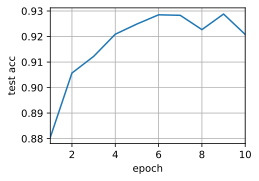

In [8]:
train(num_gpus=1, batch_size=256, lr=0.1)

接下来我们使用2个GPU进行训练。与 :numref:`sec_multi_gpu` 中评估的LeNet相比，ResNet-18的模型要复杂得多。这就是并行化显示其优势的地方。计算时间明显大于同步参数的时间。这提高了可伸缩性，因为并行化的开销不太相关。


test acc: 0.70, 6.9 sec/epoch on [gpu(0), gpu(1)]


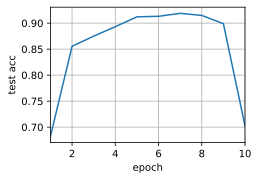

In [9]:
train(num_gpus=2, batch_size=512, lr=0.2)

## 小结


* Gluon通过提供上下文列表，为跨多个设备的模型初始化提供原语。


* 在可以找到数据的设备上自动评估数据。
* 在尝试访问每台设备上的参数之前，请注意初始化该设备上的网络。否则，你将遇到错误。
* 优化算法在多个GPU上自动聚合。

## 练习


1. 本节使用ResNet-18。尝试不同的迭代周期数、批量大小和学习率。使用更多GPU进行计算。如果使用16个GPU（例如，在AWS p2.16xlarge实例上）尝试此操作，会发生什么情况？
1. 有时，不同的设备提供不同的计算能力。我们可以同时使用GPU和CPU。我们应该如何分工？值得付出努力吗？为什么呢？
1. 如果我们丢掉`npx.waitall()`会发生什么？你将如何修改训练，以使并行操作最多有两个步骤重叠？


[Discussions](https://discuss.d2l.ai/t/2804)
